In [1]:
import tensorflow as tf

# Transfer Learning with TensorFlow Part 2: Fine-Tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning

## Creating helper functions

In previous notebooks, we've created  bunch of helper functions, now we could rewrite them all, however, this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).

In [2]:
# Import helper functions we're going to use in this notebook

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

This is we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [3]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("../data/10_food_classes_10_percent/")

There are 2 directories and 0 images in '../data/10_food_classes_10_percent/'.
There are 10 directories and 0 images in '../data/10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '../data/10_food_classes_10_percent/test\chicken_curry'.
There are 0 directories and 250 images in '../data/10_food_classes_10_percent/test\chicken_wings'.
There are 0 directories and 250 images in '../data/10_food_classes_10_percent/test\fried_rice'.
There are 0 directories and 250 images in '../data/10_food_classes_10_percent/test\grilled_salmon'.
There are 0 directories and 250 images in '../data/10_food_classes_10_percent/test\hamburger'.
There are 0 directories and 250 images in '../data/10_food_classes_10_percent/test\ice_cream'.
There are 0 directories and 250 images in '../data/10_food_classes_10_percent/test\pizza'.
There are 0 directories and 250 images in '../data/10_food_classes_10_percent/test\ramen'.
There are 0 directories and 250 images in '../data/10_food_classes_10_p

In [4]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
train_dir = "../data/10_food_classes_10_percent/train/"
test_dir = "../data/10_food_classes_10_percent/test/"

train_data = image_dataset_from_directory(directory=train_dir,
                                          label_mode="categorical",
                                          batch_size=BATCH_SIZE,
                                          image_size=IMAGE_SHAPE,
                                          seed=42)

test_data = image_dataset_from_directory(directory=test_dir,
                                         label_mode="categorical",
                                         batch_size=BATCH_SIZE,
                                         image_size=IMAGE_SHAPE,
                                         seed=42)

print(" ")
print("Train data classes")
print(train_data.class_names)

# Нормализация входных данных
normalization_layer = layers.Rescaling(1./255)

# Применяем нормализацию к данным
# train_data = train_data.map(lambda x, y: (normalization_layer(x), y))
# test_data = test_data.map(lambda x, y: (normalization_layer(x), y))

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.
 
Train data classes
['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon', 'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi']



In [5]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [6]:
# See an example of a batch of data
for images, labels in train_data.take(1):
    print(images, labels)

tf.Tensor(
[[[[1.10000000e+02 6.32397957e+01 0.00000000e+00]
   [1.18780609e+02 7.49744949e+01 7.37755108e+00]
   [1.06168365e+02 6.54438782e+01 1.02551079e+00]
   ...
   [9.51429443e+01 5.70000000e+01 2.21426392e+00]
   [1.04714348e+02 6.15000267e+01 8.57146740e+00]
   [1.10357109e+02 6.33571091e+01 9.35710812e+00]]

  [[1.14693878e+02 7.08877563e+01 4.36224604e+00]
   [1.14423470e+02 7.30051041e+01 7.14285660e+00]
   [1.10346939e+02 7.12346954e+01 6.29081631e+00]
   ...
   [9.44694366e+01 5.59285736e+01 1.34179497e+00]
   [1.00285751e+02 5.70714264e+01 4.14286995e+00]
   [1.07311264e+02 5.74490089e+01 4.40309334e+00]]

  [[1.07239792e+02 6.82346954e+01 7.65306503e-02]
   [1.13382652e+02 7.48112259e+01 7.59694004e+00]
   [1.13469383e+02 7.48520432e+01 9.94387722e+00]
   ...
   [9.81888351e+01 5.96173630e+01 5.04589176e+00]
   [1.02857155e+02 5.68571548e+01 4.85715580e+00]
   [1.09576607e+02 5.95766068e+01 6.57660770e+00]]

  ...

  [[9.08060455e+01 6.93775177e+01 2.37751961e+00]
   [9

## Model 0: Building a transfer learning model using the Keras Functional API

The sequentional API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models.

In [7]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normilize inputs (you don't have to for EfficientNet(s))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

# 10. Fit the model
model_0_history = model_0.fit(train_data, 
                             epochs=5,
                             validation_data=test_data,
                             validation_steps=int(0.25 * len(test_data)),
                             callbacks=[create_tensorboard_callback(dir_name="transfer_learning", 
                                                                   experiment_name="10_percent_feature_extraction")])


Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20250404-115528
Epoch 1/5


24/24 [==============================] - 38s 1s/step - loss: 0.0390 - accuracy: 0.4013 - val_loss: 0.0221 - val_accuracy: 0.7138
Epoch 2/5
24/24 [==============================] - 22s 928ms/step - loss: 0.0208 - accuracy: 0.7187 - val_loss: 0.0176 - val_accuracy: 0.7911
Epoch 3/5
24/24 [==============================] - 28s 1s/step - loss: 0.0172 - accuracy: 0.8093 - val_loss: 0.0148 - val_accuracy: 0.8470
Epoch 4/5
24/24 [==============================] - 19s 773ms/step - loss: 0.0145 - accuracy: 0.8440 - val_loss: 0.0140 - val_accuracy: 0.8602
Epoch 5/5
24/24 [==============================] - 16s 664ms/step - loss: 0.0125 - accuracy: 0.8987 - val_loss: 0.0135 - val_accuracy: 0.8651


In [8]:
model_0.evaluate(test_data)

79/79 [==============================] - 28s 353ms/step - loss: 0.0140 - accuracy: 0.8624


[0.014048576354980469, 0.8623999953269958]

In [9]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling_1
2 normalization
3 rescaling_2
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation

In [10]:
# How abaout we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        7         ['rescaling_1[0][0]']         
 on)                                                                                              
                                                                                                  
 rescaling_2 (Rescaling)     (None, None, None, 3)        0         ['normalization[0

In [11]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
__________________

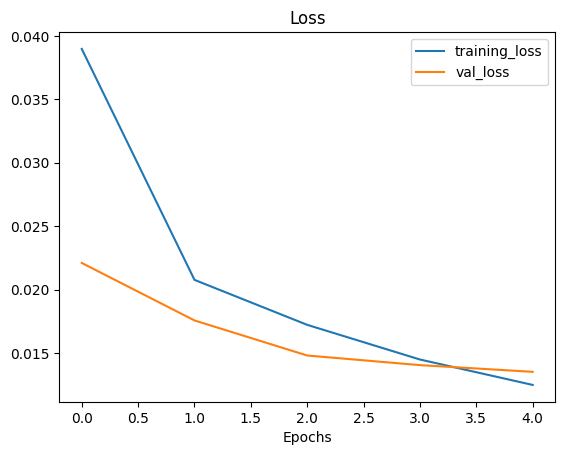

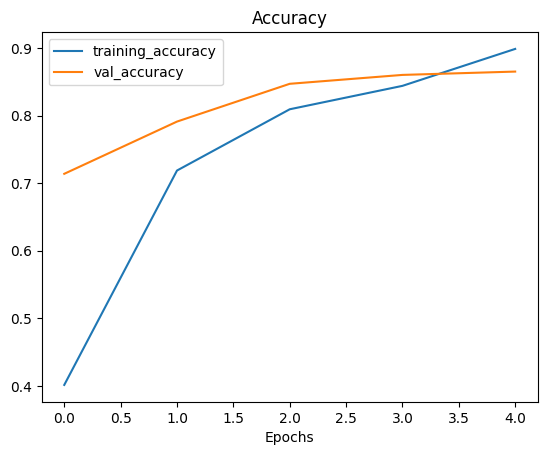

In [12]:
# Check out our model's training curves
plot_loss_curves(model_0_history)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280)...

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [13]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor} \n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840445 -0.28855976]] 

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [14]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

> **Note:** One of the reasons feture extraction transfer learning is named how it is because what often happens is pretrained model outputs a **feature vector** a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer which can then be used to extract patterns out of for our own specific problem.

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

> **Note:** throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics

### Getting and preprocessing data for model_1

In [15]:
# Create training and test dirs
train_dir_1_percent = "../data/10_food_classes_1_percent/train/"
test_dir = "../data/10_food_classes_1_percent/test/"

In [16]:
# How many images we work with
walk_through_dir("../data/10_food_classes_1_percent/")

There are 2 directories and 0 images in '../data/10_food_classes_1_percent/'.
There are 10 directories and 0 images in '../data/10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '../data/10_food_classes_1_percent/test\chicken_curry'.
There are 0 directories and 250 images in '../data/10_food_classes_1_percent/test\chicken_wings'.
There are 0 directories and 250 images in '../data/10_food_classes_1_percent/test\fried_rice'.
There are 0 directories and 250 images in '../data/10_food_classes_1_percent/test\grilled_salmon'.
There are 0 directories and 250 images in '../data/10_food_classes_1_percent/test\hamburger'.
There are 0 directories and 250 images in '../data/10_food_classes_1_percent/test\ice_cream'.
There are 0 directories and 250 images in '../data/10_food_classes_1_percent/test\pizza'.
There are 0 directories and 250 images in '../data/10_food_classes_1_percent/test\ramen'.
There are 0 directories and 250 images in '../data/10_food_classes_1_percent/test

In [17]:
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                          label_mode="categorical",
                                                                          image_size=IMG_SIZE,
                                                                          batch_size=BATCH_SIZE) # default = 32
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode="categorical",
                                                               image_size=IMG_SIZE,
                                                               batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

We can see the benefits of doing this within the TensorFlow Data augmentation documentation

Off the top our of heads, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmentation them) happens on the GPU (much faster) rather than the CPU
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./255) # Keep for models like ResNet50V2 but Efficientnet's having rescaling build in
], name="data_augmentation")

### Visualize our data augmentation layer (and see what happens to our data)

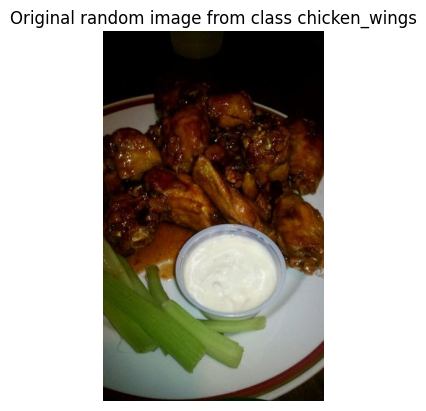

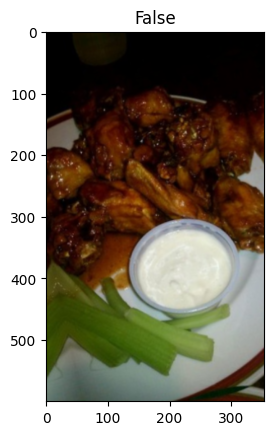

In [19]:
# View a random image and compare it to its augmentad version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "../data/10_food_classes_1_percent/train/" + "/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0), training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.title(False);

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [20]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name='input_layer')

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                               epochs=5,
                               validation_data=test_data,
                               validation_steps=int(0.25 * len(test_data)),
                               # Track model training logs
                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20250404-115808
Epoch 1/5
3/3 [==============================] - 16s 5s/step - loss: 2.4867 - accuracy: 0.0571 - val_loss: 2.3296 - val_accuracy: 0.1299
Epoch 2/5
3/3 [==============================] - 8s 4s/step - loss: 2.2077 - accuracy: 0.2429 - val_loss: 2.1931 - val_accuracy: 0.2270
Epoch 3/5
3/3 [==============================] - 9s 5s/step - loss: 1.9880 - accuracy: 0.3571 - val_loss: 2.0890 - val_accuracy: 0.2845
Epoch 4/5
3/3 [==============================] - 8s 4s/step - loss: 1.8195 - accuracy: 0.5000 - val_loss: 1.9908 - val_accuracy: 0.3635
Epoch 5/5
3/3 [==============================] - 7s 3s/step - loss: 1.7148 - accuracy: 0.6429 - val_loss: 1.8785 - val_accuracy: 0.4326


In [21]:
# Check out a model
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [22]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 29s 363ms/step - loss: 1.8788 - accuracy: 0.4120


[1.8788254261016846, 0.41200000047683716]

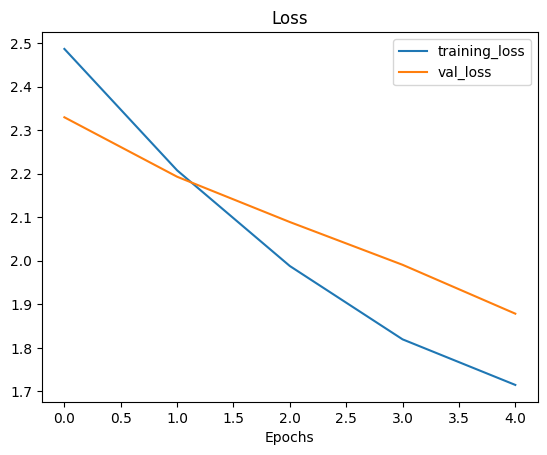

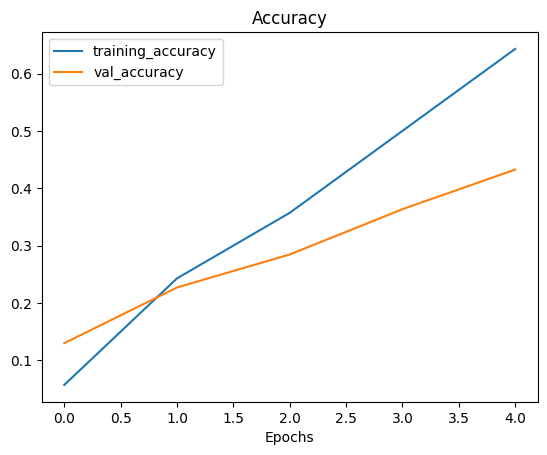

In [23]:
# How do the model with 1% of the data and data augmentation loss curves look?
plot_loss_curves(history_1_percent)

## Model 2: Feature extraction transfer learning model with 10% of data and data augmentation

In [24]:
train_dir_10_percent = "../data/10_food_classes_10_percent/train/"

test_dir = "../data/10_food_classes_10_percent/test"

In [25]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_10_percent,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [26]:
# Create model 2 with data augmentation build in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./255) # Keep for models like ResNet50V2 but Efficientnet's having rescaling build in
], name="data_augmentation")

# Setup input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name='input_layer')
x = data_augmentation(inputs) # augment our training data
x = base_model(x, training=False) # pass the augmented data to the model but keep it in inference mode, this also insures batchnorm layers don't get updated
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [27]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_2D   (None, 1280)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

### Creating a modelCheckpoint callback

The modelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.

In [28]:
# Set checkpoint path
checkpoint_path = "../ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a modelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        save_weights_only=True,
                                                        save_best_only=False,
                                                        save_freq="epoch",
                                                        verbose=1)

### Fit model 2 passing in ModelCheckpoint callback

In [29]:
# Fit the model and saving checkpoints wvery epochs
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                experiment_name="10_percent_data_aug"),
                                                    checkpoint_callback]
)

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20250404-115928
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 0.4320 - accuracy: 0.1947  
Epoch 1: saving model to ../ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 33s 1s/step - loss: 0.4320 - accuracy: 0.1947 - val_loss: 0.2976 - val_accuracy: 0.4655
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 0.2737 - accuracy: 0.5787 
Epoch 2: saving model to ../ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 21s 867ms/step - loss: 0.2737 - accuracy: 0.5787 - val_loss: 0.2379 - val_accuracy: 0.7089
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.2293 - accuracy: 0.7093 
Epoch 3: saving model to ../ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 20s 844ms/step - loss: 0.2293 - accuracy: 0.7093 - val_loss: 0.2013 - val_accuracy

In [30]:
model_0.evaluate(test_data)

79/79 [==============================] - 31s 383ms/step - loss: 0.0140 - accuracy: 0.8624


[0.014048581011593342, 0.8623999953269958]

In [31]:
model_1.evaluate(test_data)

79/79 [==============================] - 29s 360ms/step - loss: 1.8788 - accuracy: 0.4120


[1.8788254261016846, 0.41200000047683716]

In [32]:
results_10_percent_data_aug = model_2.evaluate(test_data)

79/79 [==============================] - 31s 388ms/step - loss: 0.1657 - accuracy: 0.8172


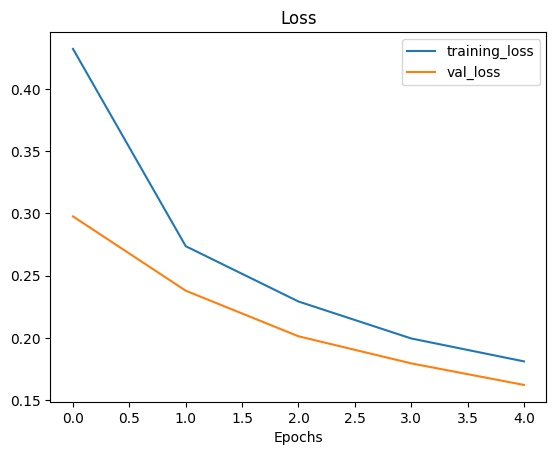

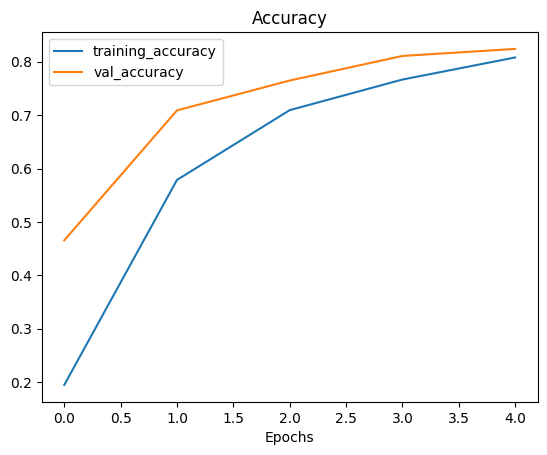

In [33]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

### Loading in checpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint.

In [34]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [35]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)
loaded_weights_model_results

79/79 [==============================] - 28s 347ms/step - loss: 0.1657 - accuracy: 0.8172


[0.16565309464931488, 0.8172000050544739]

In [36]:
# If the results from our previously evaluated model_2 match the loaded weights, everything is fine
results_10_percent_data_aug == loaded_weights_model_results

False

In [37]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [38]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[4.47034836e-08 0.00000000e+00]


## Model 3: Fine-tuning an existing model on 10% of the data

> **Note:** Fine-tuning usially works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [39]:
# Layers in our loaded model
model_2.layers

In [40]:
# Are these layers trainable?
for layer in model_2.layers:
    print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x0000020FD1117290> True
<keras.src.engine.sequential.Sequential object at 0x000002100FE2CB90> True
<keras.src.engine.functional.Functional object at 0x0000020FD114F790> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x0000021010183A90> True
<keras.src.layers.core.dense.Dense object at 0x00000210102BE950> True


In [41]:
# What layers are in our base_model (EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_5 False
2 normalization_2 False
3 rescaling_6 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [42]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [43]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile (we have to recompile our model every time we make a change)
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # when fine-tuning you typically want to lower the learning rate by 10x
                metrics=["accuracy"])

> **Note:** When using fine-tuning it's best practice to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. But a good rule of thumb is at least 10x (though different sources will claim other values).

In [44]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_5 False
2 normalization_2 False
3 rescaling_6 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [45]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables do we have
print(len(model_2.trainable_variables))

12


In [46]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start training from previous last epoch
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20250404-120323
Epoch 5/10
24/24 [==============================] - 30s 983ms/step - loss: 0.7321 - accuracy: 0.7987 - val_loss: 0.5269 - val_accuracy: 0.8306
Epoch 6/10
24/24 [==============================] - 22s 928ms/step - loss: 0.5811 - accuracy: 0.8320 - val_loss: 0.4942 - val_accuracy: 0.8355
Epoch 7/10
24/24 [==============================] - 21s 864ms/step - loss: 0.4972 - accuracy: 0.8533 - val_loss: 0.4502 - val_accuracy: 0.8586
Epoch 8/10
24/24 [==============================] - 22s 916ms/step - loss: 0.4446 - accuracy: 0.8813 - val_loss: 0.4453 - val_accuracy: 0.8536
Epoch 9/10
24/24 [==============================] - 20s 838ms/step - loss: 0.3969 - accuracy: 0.8827 - val_loss: 0.4203 - val_accuracy: 0.8520
Epoch 10/10
24/24 [==============================] - 21s 866ms/step - loss: 0.3605 - accuracy: 0.8973 - val_loss: 0.4197 - val_accuracy: 0.8602


In [47]:
# Evaluate the fine-tuned model (model_3 which is actualy model_2 fine-tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)
results_fine_tune_10_percent

79/79 [==============================] - 29s 366ms/step - loss: 0.4332 - accuracy: 0.8560


[0.43324199318885803, 0.8560000061988831]

In [48]:
results_10_percent_data_aug

[0.16565313935279846, 0.8172000050544739]

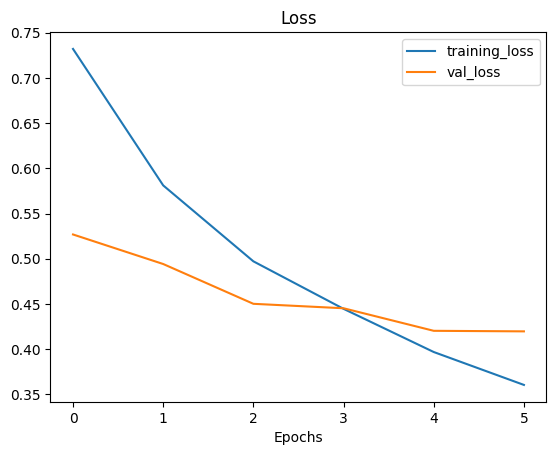

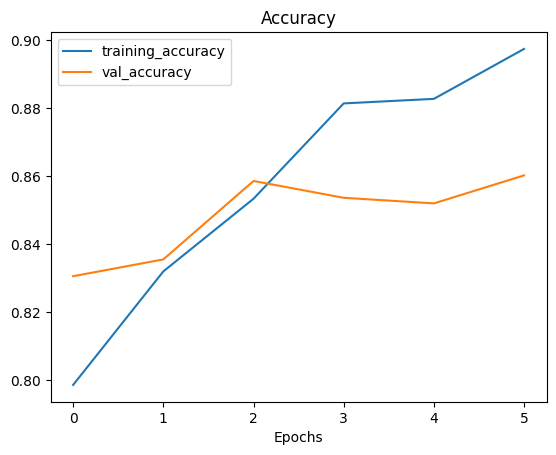

In [49]:
# Check out the loss curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running `fit()` which another (e.g. before and after fine-tuning)

In [53]:
# Let's create a function to compare training histories
def compare_histories(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow History objects
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history metrics wit new_history metrics
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots for accuracy
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label="Training Accuracy")
    plt.plot(total_val_acc, label="Val Accuracy")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")

    # Make plots for loss
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label="Training Loss")
    plt.plot(total_val_loss, label="Val Loss")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Loss")

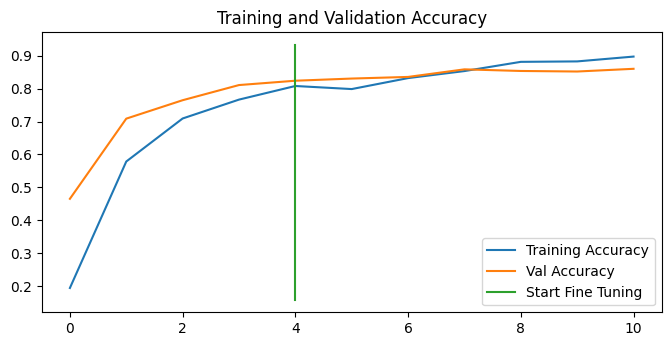

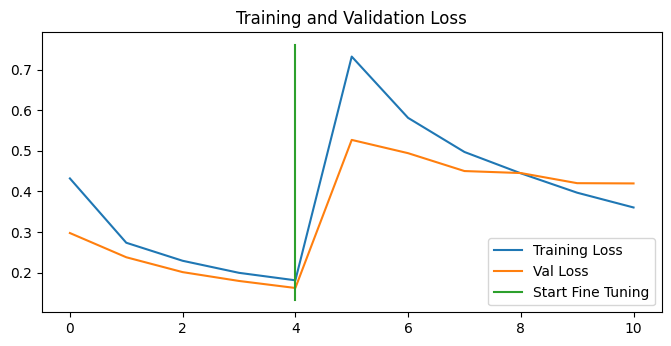

In [54]:
compare_histories(history_10_percent_data_aug,
                  history_fine_10_percent_data_aug,
                  initial_epochs=5)